In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas

from collections import defaultdict, Counter

<img src="img/Exercise10.png" width=600>

# Let's get the posterior $p( a, b | \vec{d} )$

In [35]:
from utilities import flat, truncated_jeffreys

In [36]:
def prior_b(b):
    return truncated_jeffreys(b, lower=0.04, upper=25) / (np.log(25) - np.log(0.04))

prior_b(0)


0.0

In [37]:

def prior_a(b):
    return flat(b, lower=0, upper=10) 

In [38]:
def func(x, a, b):
    return a * np.cos(b*x)

In [39]:
data = list(zip(
    np.array([1.5]),
    np.array([1.6])
))
data[:1]

[(1.5, 1.6)]

In [40]:
d1 = data[:1]
d1

[(1.5, 1.6)]

In [41]:
def likelihood(a, b, data, sigma=0.5, f=func):
    """p(data | a, b)"""
    exponent = - 0.5 * np.sum([
        (y - f(x, a, b))**2 for x, y in data
    ], axis=0) / sigma**2

    return np.exp(exponent) / (sigma * np.sqrt(2*np.pi))

likelihood(1, 1, data=data[:1])

0.007423677197594808

In [42]:
def posterior_a_b(a, b, data):
    p = likelihood(a, b, data=data) * prior_a(a) * prior_b(b)
    return p

posterior_a_b(1,2, data=data[:1])

9.239064070089734e-09

/var/folders/y5/v1z7p_cs5r52n2kw2rl1bymc0000gp/T/ipykernel_36302/3274253523.py:9: RuntimeWarning: divide by zero encountered in log
  aa, bb, np.log(p)


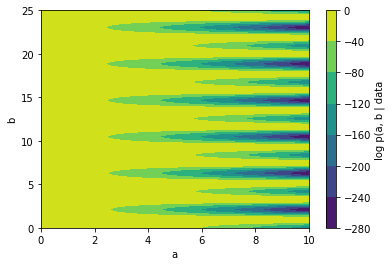

In [43]:
aa, bb = np.meshgrid(
    np.linspace(0, 10, 1000),
    np.linspace(0, 25, 1000)
)

p = posterior_a_b(aa, bb, data=d1)

plt.contourf(
    aa, bb, np.log(p)
)

plt.xlabel("a")
plt.ylabel("b")
cbar = plt.colorbar()
cbar.set_label("log p(a, b | data")

In [44]:
np.max(p)

0.2476247056130366

## Norm the posterior

In [45]:
N = 10000
aa, bb = np.meshgrid(
    np.linspace(0, 25, N),
    np.linspace(0, 8, N)
)

p = posterior_a_b(aa, bb, data=d1)

np.sum(p) * np.mean(np.diff(aa[0, :])) * np.mean(np.diff(bb[:, 0]))


0.08146506478576912

In [46]:
Z_posterior = scipy.integrate.dblquad(
    lambda y, x: posterior_a_b(a=x, b=y, data=d1),
    0, 25, # limits for a
    0, 7, # limits for b
)[0]
Z_posterior

0.0786246372373017

In [47]:
def posterior_a_b_normed(a, b, data):
    return posterior_a_b(a, b, data=data) / Z_posterior

scipy.integrate.dblquad(
    lambda y, x: posterior_a_b_normed(x, y, data=d1),
    0, 25, # limits for a
    0, 7, # limits for b
)

(1.0000001217604622, 1.4896128597628064e-08)

# Sample the posterior (via rejection method)

In [48]:
sigma = 0.5

# max of prior a: 1/x, where x=lower boundary --> 1/0.04
# max of prior a: 1/7

# max of posterior:
1/(sigma * np.sqrt(2 * np.pi)) * (1/10) * (1/0.04) * (1/(np.log(25/0.04))) #/ Z_posterior

0.30984596960785815

In [49]:
def envelope(a, b, value=8):
    """Estimate for max of posterior see above --> value"""

    # check the boundaries
    L = prior_a(a) * prior_b(b) != 0

    r = np.zeros_like(a)
    r[L] = value
    return r


Text(0, 0.5, 'b')

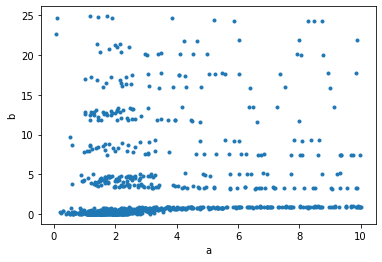

In [53]:
def inverse_sampling_of_a_b(N, blocksize=None, data=d1):

    if blocksize is None:
        blocksize = N

    sampled_values_a = []
    sampled_values_b = []
    
    while len(sampled_values_a) < N:

        u = np.random.rand(blocksize)
        
        y = (np.random.rand(blocksize, 2) * np.array([10, 25])).transpose()
        
        
        #is_accepted = u > (prior_function(y) / envelope_function(y))
        is_accepted = (u * envelope(*y)) < posterior_a_b_normed(*y, data=data)
        
        sampled_values_a += list(y[0, is_accepted])
        sampled_values_b += list(y[1, is_accepted])

        #break
    return np.asarray(sampled_values_a[:N]), np.asarray(sampled_values_b[:N])


samples_a, samples_b = inverse_sampling_of_a_b(
    N=1000,
    #blocksize=10000,
    data=data
)

plt.plot(samples_a, samples_b, ".")
plt.xlabel("a")
plt.ylabel("b")


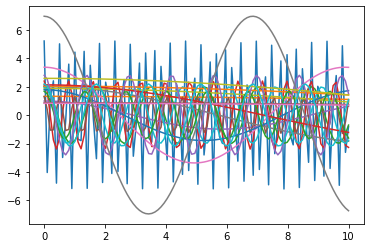

In [54]:
t = np.linspace(0, 10, 100)
for a, b in zip(samples_a[:20], samples_b[:20]):

    plt.plot(t, func(t, a, b))

# get p(D| t, a, b)

In [69]:
def probability_for_D(D, t, a, b, sigma=0.5, f=func):

    N = a.size

    exponent = -0.5 * np.sum([(D - f(t, aa, bb))**2 for aa, bb in zip(a, b)], axis=0) / sigma**2

    return 1/sigma * 1/np.sqrt(2*np.pi) * np.exp(exponent) / N

probability_for_D(2, 1, samples_a, samples_b)

0.0

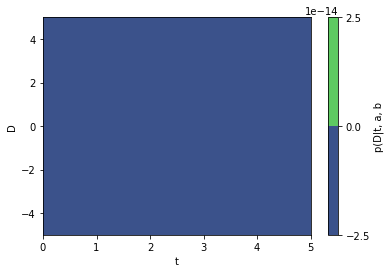

In [73]:
t, D = np.meshgrid(
    np.linspace(0, 5, 100),
    np.linspace(-5, 5, 100)
)

plt.contourf(
    t, D, 
    probability_for_D(D, t, a=samples_a, b=samples_b)
    #np.log(probability_for_D(D, t, a=samples_a, b=samples_b))
)

plt.xlabel("t")
plt.ylabel("D")

cbar = plt.colorbar()
cbar.set_label("p(D|t, a, b")

In [98]:


def probability_a_b_given_D_t_d(a, b, D, t, data, f=func, sigma=0.5):
    """p(a, b | D, t, d) = p(D |a, b, t, d) * p(a, b | t, d) / p(D|t, d)"""

    # p(D|a, b, t, (d))
    p = np.exp(-0.5 * (D-f(t, a, b))**2 / sigma**2) / (sigma * np.sqrt(2 * np.pi))

    return p * posterior_a_b_normed(a, b, data=data) / \
        probability_for_D(D, t, a=samples_a, b=samples_b, sigma=sigma, f=func)

def I(D, t, data): 
    
    return scipy.integrate.dblquad(
        lambda y, x: probability_a_b_given_D_t_d(a=x, b=y, D=D, t=t, data=data) * (
            np.log(probability_a_b_given_D_t_d(a=x, b=y, D=D, t=t, data=data)) * \
                posterior_a_b_normed(a=x, b=y, data=data)
        ),
        0, 10, # limits for a
        0, 25, # limits for b
    ) 

I(0, 2, data=data[:1])

/var/folders/y5/v1z7p_cs5r52n2kw2rl1bymc0000gp/T/ipykernel_36302/344474466.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return p * posterior_a_b_normed(a, b, data=data) / \


(inf, inf)

In [97]:

N = 2
t, D = np.meshgrid(
    np.linspace(0, 5, N),
    np.linspace(-5, 5, N)
)

II = np.array([I(DD, tt, data=data[:1]) for DD, tt in zip(t.flatten(), D.flatten())]).reshape(N, N)

plt.contourf(t, D, II)

/var/folders/y5/v1z7p_cs5r52n2kw2rl1bymc0000gp/T/ipykernel_36302/1579940925.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return p * posterior_a_b_normed(a, b, data=data) / \


ValueError: cannot reshape array of size 8 into shape (2,2)

In [95]:
II

array([[None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None]],
      dtype=object)

In [66]:
data

[(1.5, 1.6)]